## Figure S2: spatial index longitudinal

*Last update: 2022-05-17*


In [1]:
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from pathlib import Path
from scipy.stats import linregress
import importlib

from trial import Trial
from util import dist
from constants import COND_LABELS, FS, DV_LABELS
import plots
import pyreadstat
import analysis_helper

importlib.reload(plots)
importlib.reload(analysis_helper)

plt.style.use('./jg.mplstyle')

### Load data

In [2]:
df_trials = pd.read_pickle('../data/df_trials_v4_spatial.pickle')

In [3]:
# Drop practice
df_trials = df_trials[df_trials.practice == 0]

In [4]:
# Define spatial index as average cross-trial occupancy (prob of self) distance
# from 0.5 for each player, on all cells visited in trial
# Cross-trial occupancy probabilities are constructed from nearest 20 trials (forward and backward)

def compute_spatial_index(k=5, strategy="pct_moves_majority"):
    for match_nick in df_trials.match_nick.unique():
        for key, row in df_trials[df_trials.match_nick == match_nick].iterrows():
            block = 1 if row['cond_count'] == row['first_counter_block'] else 2
            min_trial = 1 if block == 1 else 42
            max_trial = 40 if block == 1 else 81            
            trial_start = int(max([row['trial']-k, min_trial]))
            trial_end = int(min([trial_start+2*k, max_trial]))
            heatmap_p0 = np.zeros((11, 11))
            heatmap_p1 = np.zeros((11, 11))
            trange = range(trial_start, trial_end+1)
            # print("Computing probability/heatmap from trials: %s" % trange)
            for trial_id in trange:
                trials = df_trials[(df_trials.match_nick == match_nick) &
                                          (df_trials.trial == trial_id)]
                if len(trials):
                    trial = trials.iloc[0]
                    _occ_p0 = np.array(json.loads(trial['occupancy_p0']))
                    _occ_p1 = np.array(json.loads(trial['occupancy_p1']))    
                    heatmap_p0 += _occ_p0
                    heatmap_p1 += _occ_p1
                else:
                    print("Missing trial %s" % trial_id)
            nonzero = (heatmap_p0 + heatmap_p1) > 0
            heatmap = np.zeros(heatmap_p0.shape)
            heatmap[nonzero] = heatmap_p0[nonzero]/(heatmap_p0[nonzero] + heatmap_p1[nonzero])
            heatmap[~nonzero] = 0.5
            if strategy == "pct_moves_majority":
                heatmap[heatmap > 0.5] = 1.0
                heatmap[heatmap < 0.5] = 0.0                

            # Now compute spatial index from this trial's occupancy and heatmap in 20 nearby trials
            occupancy_p0 = np.array(json.loads(row['occupancy_p0']))
            occupancy_p0[5, 5] = 0  # Clear middle
            occupancy_p1 = np.array(json.loads(row['occupancy_p1']))  
            occupancy_p1[5, 5] = 0  # Clear middle
            p0_n = occupancy_p0.sum()
            p1_n = occupancy_p1.sum()
            mean_prob = []
            prod_prob = 1.0
            if p0_n:
                p0_prob = (occupancy_p0 * heatmap).sum()/p0_n
                mean_prob.append(p0_prob)
                prod_prob *= p0_prob
            if p1_n:
                p1_prob = (occupancy_p1 * (1-heatmap)).sum()/p1_n
                mean_prob.append(p1_prob)
                prod_prob *= p1_prob
            df_trials.loc[key, 'spatial_heat_index'] = np.mean(mean_prob)
            df_trials.loc[key, 'spatial_heat_index_prod'] = prod_prob
            # df_trials.loc[key, 'spatial_heat_index'] = prod_prob

compute_spatial_index()

/opt/miniconda3/envs/jointaction/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/jointaction/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Missing trial 81
Missing trial 81
Missing trial 81
Missing trial 81
Missing trial 81


In [5]:
dyad_ids = {}  # Match_id -> dyad num
for match_id in df_trials.match_id.unique():
    dyad_ids[match_id] = (len(dyad_ids.keys())+1, df_trials[df_trials.match_id == match_id].iloc[0].first_counter_block)

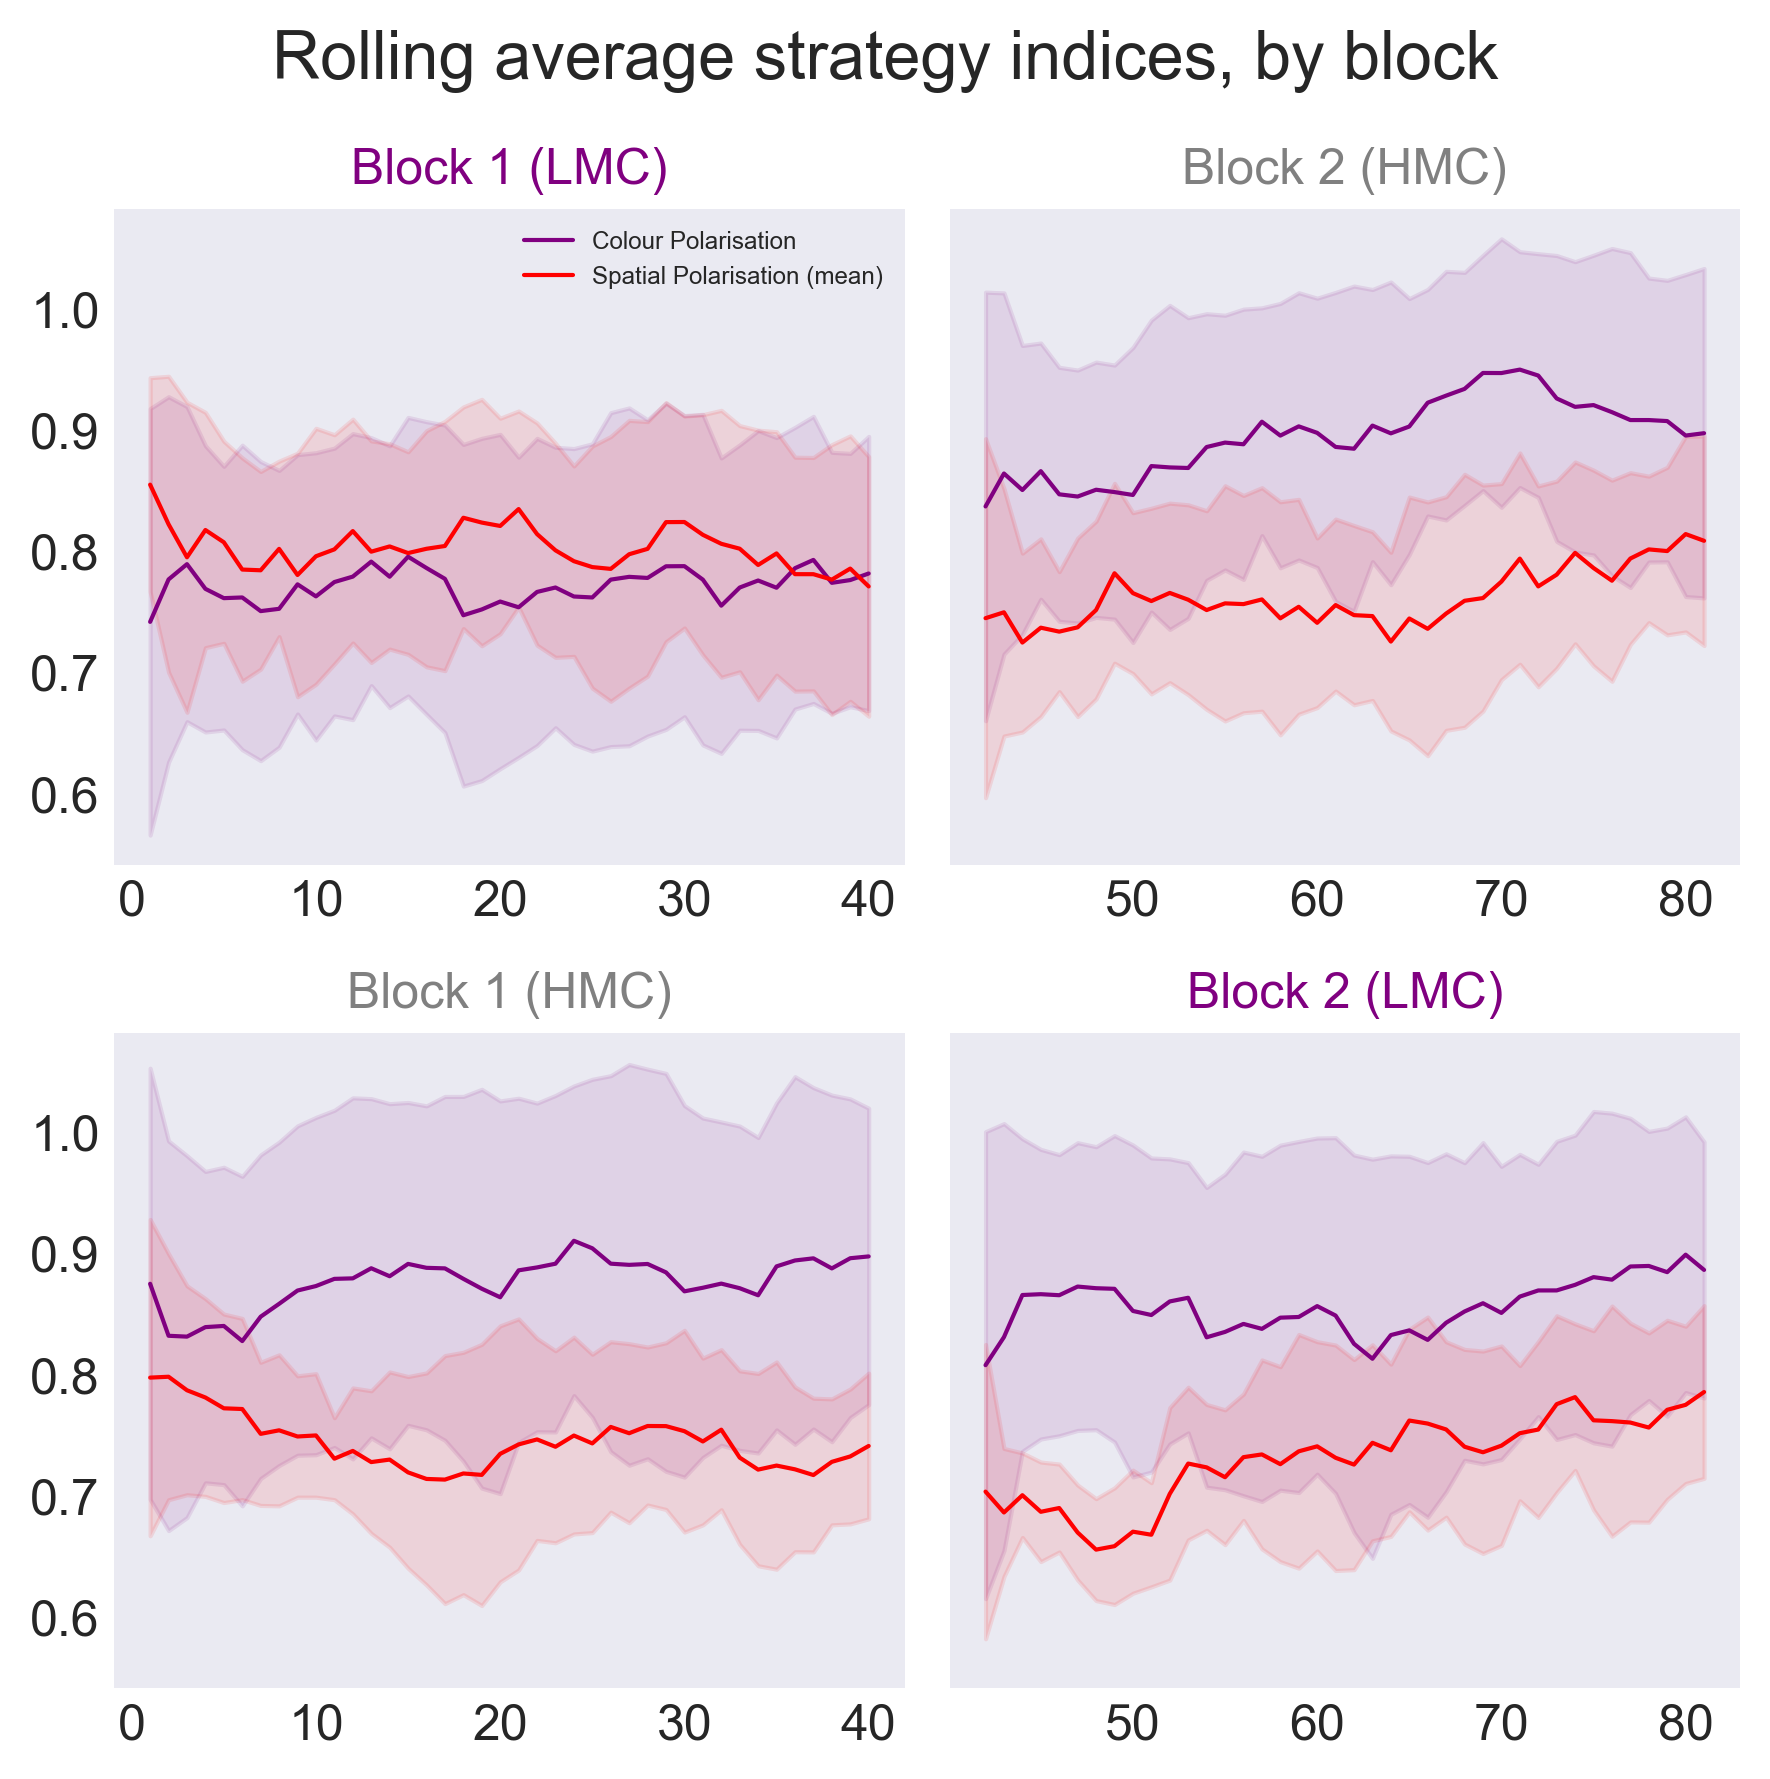

In [6]:
plots.aggregate_timeseries(df_trials, rolling_window_k=5,
                        dvs = ["goal_color_split", "spatial_heat_index"],
                         one_group=None,
                        fix_ylim=None, title="Rolling average strategy indices, by block")

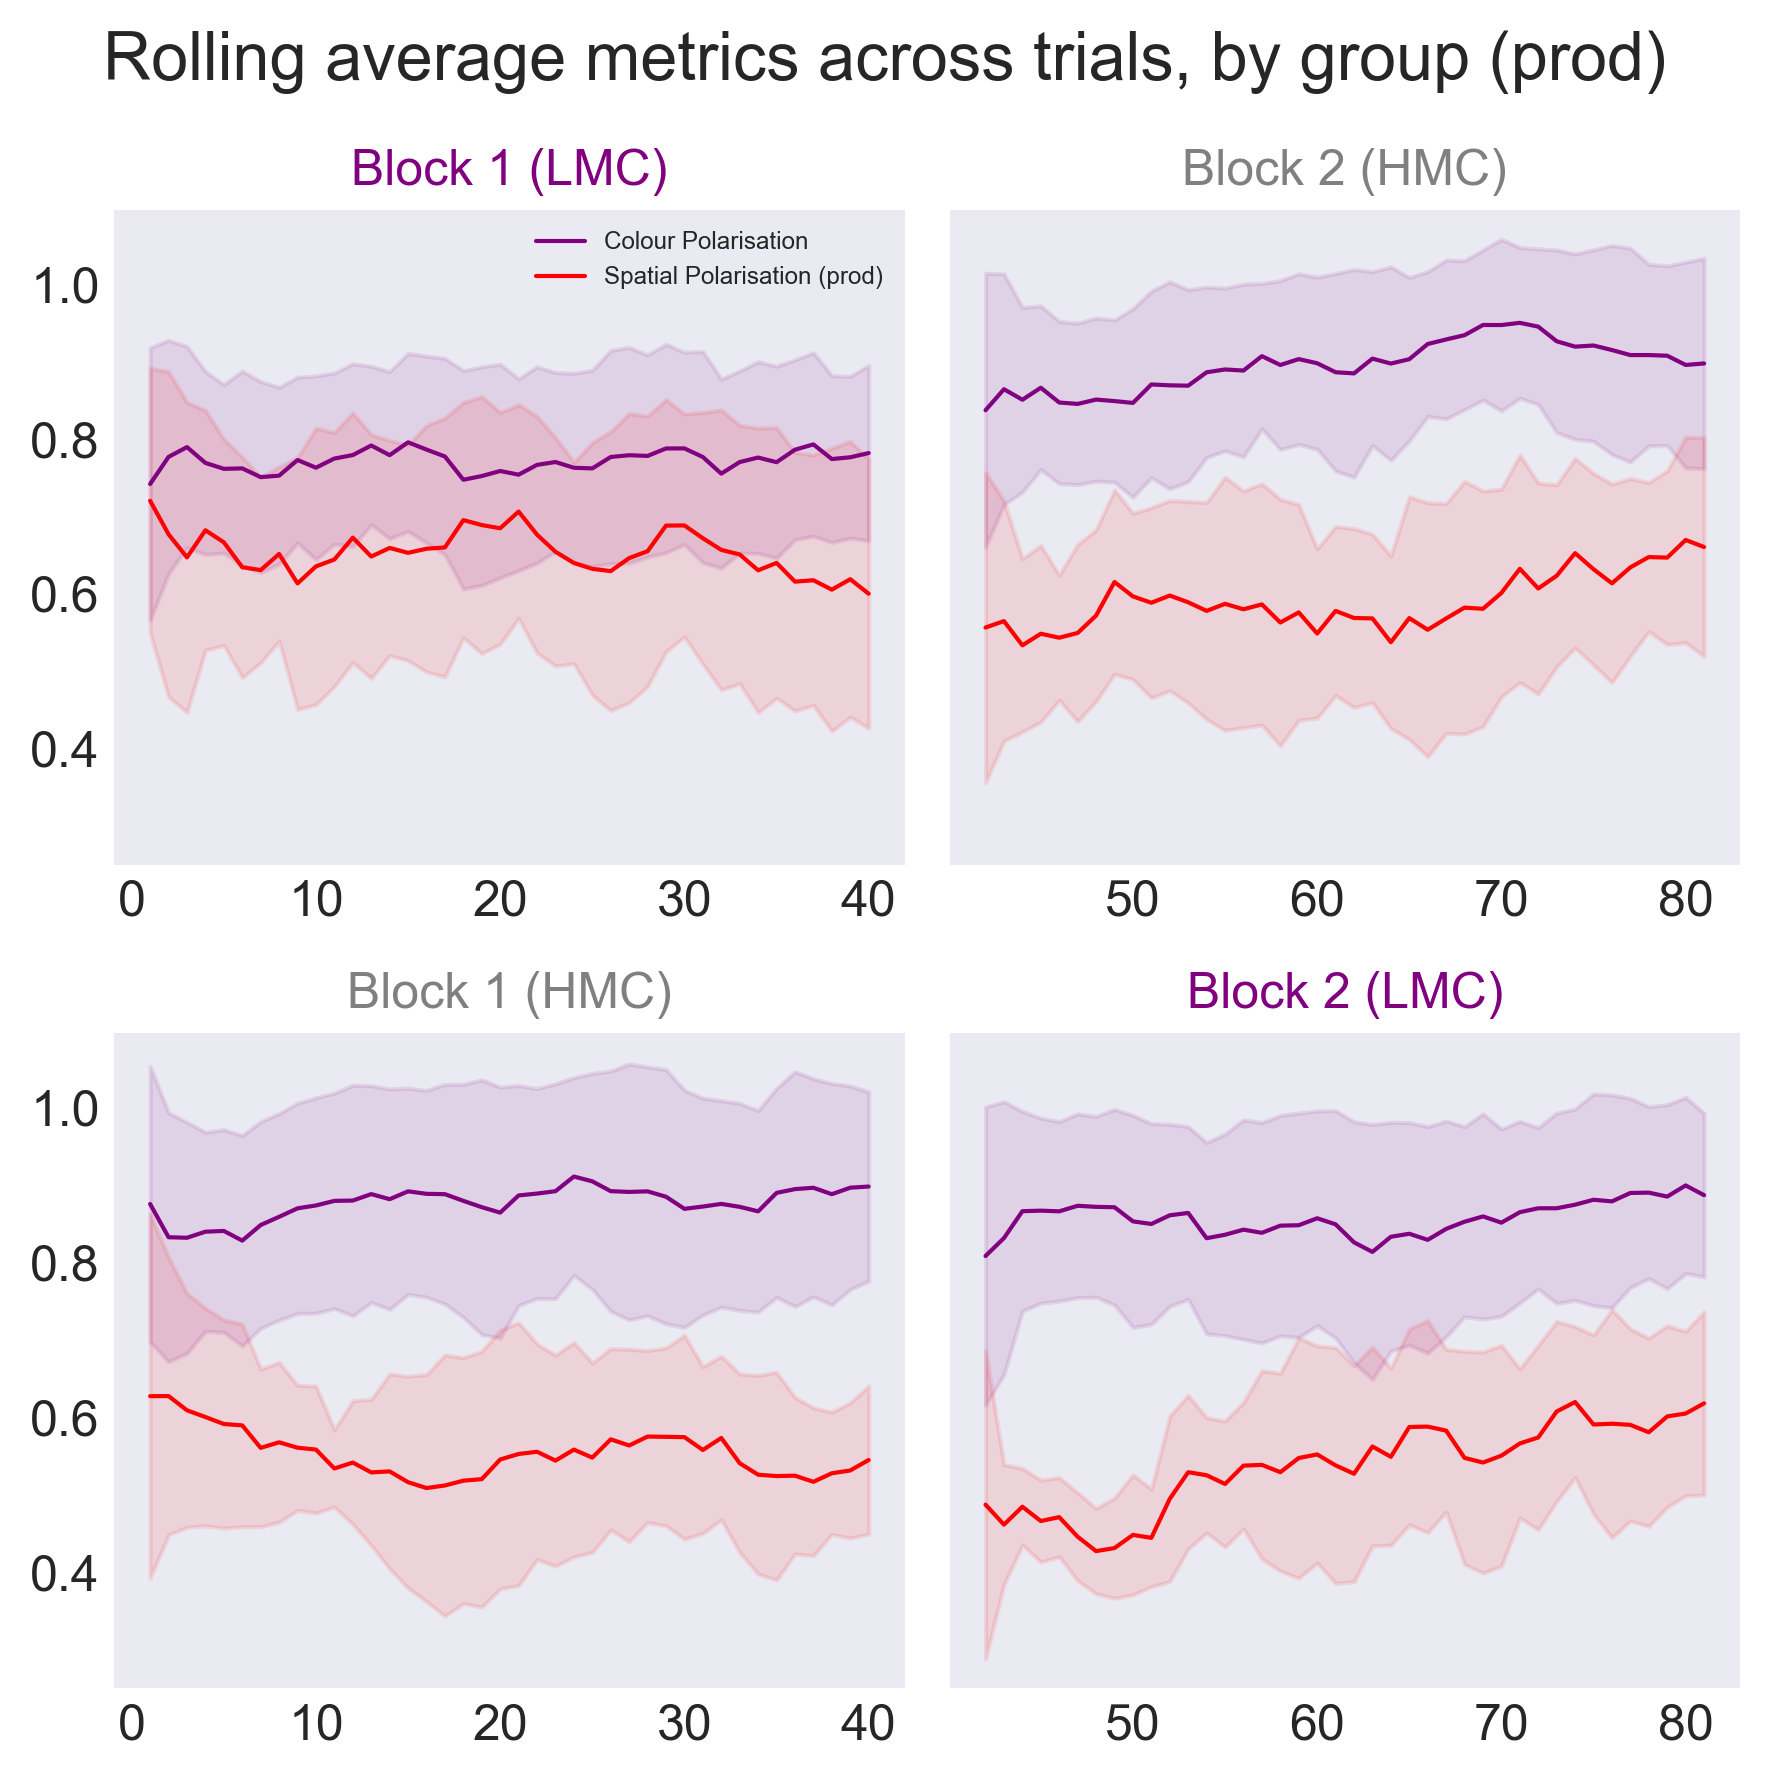

In [7]:
plots.aggregate_timeseries(df_trials, rolling_window_k=5,
                        dvs = ["goal_color_split", "spatial_heat_index_prod"],
                         one_group=None,
                        fix_ylim=None, title="Rolling average metrics across trials, by group (prod)")

In [8]:
pd.to_pickle(df_trials, '../data/df_trials_v4_spatial.pickle')